In [12]:
# import subprocess
import encode as ec
from models import speeds, model_paths, dorado, tsv_dict, make_table
from IPython.display import Markdown, display
bash = lambda commands: display(Markdown("```bash\n" + ' && \n'.join(commands) + "\n```"))

data_dir = 'prom_out'
# def run(command, **kwargs):
#   return subprocess.run(command, check=True, cwd=data_dir, **kwargs)

We prepare data by generating a random `length`nt DNA sequence and prepare it into a `.fasta` file

In [ ]:
import random

data_src_dir = 'small_out'
length = 300

sequence = ''.join(random.choices('ACGT', k=length))

with open(f'{data_src_dir}/data.txt', "w") as txt:
  txt.write(sequence)

with open(f'{data_dir}/sample.fasta', "w") as fasta:
  fasta.write(">random_sequence\n")
  for i in range(0, length, 60):
    fasta.write(sequence[i:i+60] + "\n")

f'{data_dir}/sample.fasta'

'small_out/sample.fasta'

~~We use the `Seq2Squiggle` library to obtain the pod5 prediction in `sample.pod5`~~

In [ ]:
# run([
#   "seq2squiggle", "predict", "sample.fasta",
#   "-o", "sample.pod5",
#   "--profile", "dna-r10-min",
#   "--read-input"
# ])
# bash(["seq2squiggle predict sample.fasta -o sample.pod5 --profile dna-r10-prom --read-input"])

We use the `squigulator` library to output `sample.slow5`, then use `blue_crab` to convert to `sample.pod5`

In [ ]:
bash(["squigulator sample.fasta -x dna-r10-prom -o sample.slow5 --full-contigs --ont-friendly yes --seed 42 &&\n" +
      "rm -f sample.pod5 &&\n" +
      "blue-crab s2p sample.slow5 -o sample.pod5"])

```bash
squigulator sample.fasta -x dna-r10-prom -o sample.slow5 --full-contigs --ont-friendly yes --seed 42 &&
rm -f sample.pod5 &&
blue-crab s2p sample.slow5 -o sample.pod5
```

(Deprecated) ~~Before converting to `sample.pod5`, use the below code to correctly replace the read_id of the `slow5` file with a uuid as per `blue-crab`'s requirement:~~

In [ ]:
# import uuid
# import os

# input_file = f"{data_dir}/sample.slow5"
# temp_file = f"{data_dir}/sample.slow5.tmp"

# with open(input_file, "r") as fin, open(temp_file, "w") as fout:
#   for line in fin:
#     if line.startswith("#") or line.startswith("@"):
#       fout.write(line)
#     else:
#       parts = line.strip().split('\t')
#       parts[0] = str(uuid.uuid4())
#       fout.write('\t'.join(parts) + '\n')

# os.replace(temp_file, input_file)  # Atomically replace original file

We perform our earlier workflow:

In [ ]:
# bash([f'dorado basecaller ${speed.upper()} sample.pod5 --emit-fastq > {speed}.fastq &&\n' +
#       f'dorado aligner sample.fasta {speed}.fastq > {speed}.bam &&\n' +
#       f'dorado summary {speed}.bam > {speed}.tsv'
#       for speed in speeds])

# Although, the following works equivalently by adding the --reference flag to produce .bam alignment files directly, without producing the corresponding fastq files:
bash([f'dorado basecaller ${speed.upper()} sample.pod5 --reference sample.fasta > {speed}.bam &&\n' +
      f'dorado summary {speed}.bam > {speed}.tsv'
      for speed in speeds])

```bash
dorado basecaller $FAST sample.pod5 --reference sample.fasta > fast.bam &&
dorado summary fast.bam > fast.tsv && 
dorado basecaller $HAC sample.pod5 --reference sample.fasta > hac.bam &&
dorado summary hac.bam > hac.tsv && 
dorado basecaller $SUP sample.pod5 --reference sample.fasta > sup.bam &&
dorado summary sup.bam > sup.tsv
```

In [14]:
data = {speed: tsv_dict(data_dir, speed) for speed in speeds}
make_table(data)

| Metric | fast | hac | sup |
|--------|--------|--------|--------|
| alignment_accuracy | 0.839085 | 0.8873 | 0.896138 |
| alignment_identity | 0.928882 | 0.950571 | 0.942389 |
| alignment_genome_start | 8 | 8 | 8 |
| alignment_genome_end | 3106840 | 3106840 | 3106844 |
| alignment_strand_start | 0 | 0 | 0 |
| alignment_strand_end | 2884786 | 2974607 | 3070091 |
| alignment_strand_coverage | 0.999998 | 0.999998 | 1 |
| alignment_length | 3147968 | 3145399 | 3166158 |
| alignment_num_aligned | 2843650 | 2936040 | 3010769 |
| alignment_num_correct | 2641414 | 2790913 | 2837316 |
| alignment_num_deletions | 263182 | 170792 | 96067 |
| alignment_num_insertions | 41136 | 38567 | 59322 |
| alignment_num_substitutions | 202236 | 145127 | 173453 |

We observe that the hac model is the most stable. We perform one-shot pruning (in `prune_new.ipynb`) with different sparsities and evaluate their performances with the following workflow

In [3]:
test_model_dir = '/vol/bitbucket/bl1821/pruned_models'
sparsities = [a/100 for a in range(0,40)]
pruned_models = [f'sparse_{s}' for s in sparsities]

# bash(
#   [f'dorado basecaller {test_model_dir}/{model} sample.pod5 --reference sample.fasta > {model}.bam &&\n' +
#    f'dorado summary {model}.bam > {model}.tsv' for model in pruned_models]
# )

bash([f"""for i in {' '.join([str(s) for s in sparsities])}; do
  dorado basecaller /vol/bitbucket/bl1821/pruned_models/sparse_${{i}} sample.pod5 --emit-fastq > sparse_${{i}}.fastq &&
  dorado aligner sample.fasta sparse_${{i}}.fastq > sparse_${{i}}.bam &&
  dorado summary sparse_${{i}}.bam > sparse_${{i}}.tsv
done"""])

```bash
for i in 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39; do
  dorado basecaller /vol/bitbucket/bl1821/pruned_models/sparse_${i} sample.pod5 --emit-fastq > sparse_${i}.fastq &&
  dorado aligner sample.fasta sparse_${i}.fastq > sparse_${i}.bam &&
  dorado summary sparse_${i}.bam > sparse_${i}.tsv
done
```

In [24]:
data = {model: tsv_dict("pruned_fine_out", model) for model in pruned_models}
make_table(data)

| Metric | sparse_0.0 | sparse_0.01 | sparse_0.02 | sparse_0.03 | sparse_0.04 | sparse_0.05 | sparse_0.06 | sparse_0.07 | sparse_0.08 | sparse_0.09 | sparse_0.1 | sparse_0.11 | sparse_0.12 | sparse_0.13 | sparse_0.14 | sparse_0.15 | sparse_0.16 | sparse_0.17 | sparse_0.18 | sparse_0.19 | sparse_0.2 | sparse_0.21 | sparse_0.22 | sparse_0.23 | sparse_0.24 | sparse_0.25 | sparse_0.26 | sparse_0.27 | sparse_0.28 | sparse_0.29 | sparse_0.3 | sparse_0.31 | sparse_0.32 | sparse_0.33 | sparse_0.34 | sparse_0.35 | sparse_0.36 | sparse_0.37 | sparse_0.38 | sparse_0.39 |
|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| alignment_accuracy | 0.910627 | 0.910674 | 0.910254 | 0.910479 | 0.90962 | 0.911068 | 0.910155 | 0.911879 | 0.911508 | 0.910396 | 0.91277 | 0.916324 | 0.912942 | 0.913342 | 0.914125 | 0.919216 | 0.917517 | 0.918396 | 0.917745 | 0.911877 | 0.915957 | 0.906639 | 0.911028 | 0.915215 | 0.911272 | 0.910869 | 0.90607 | 0.898715 | 0.871416 | 0.833742 | 0.796136 | 0.812754 | 0.809386 | 0.802753 | 0.75858 | 0.740826 | 0 | 0 | 0 | 0 |
| alignment_identity | 0.955717 | 0.955743 | 0.955468 | 0.955578 | 0.955149 | 0.956153 | 0.955443 | 0.956258 | 0.955871 | 0.954599 | 0.956137 | 0.95828 | 0.956389 | 0.956422 | 0.956963 | 0.959929 | 0.958474 | 0.958602 | 0.957378 | 0.953694 | 0.956604 | 0.9496 | 0.952712 | 0.955999 | 0.95363 | 0.95431 | 0.952775 | 0.947406 | 0.932165 | 0.908716 | 0.880822 | 0.895152 | 0.895683 | 0.888253 | 0.855042 | 0.838961 | 0 | 0 | 0 | 0 |
| alignment_genome_start | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 1073483 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 8 | 545208 | 8 | 524391 | 8 | 1521552 | 8 | 8 | 8 | 2161471 | 3088253 | -1 | -1 | -1 | -1 |
| alignment_genome_end | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 2499847 | 3106840 | 3106840 | 3106840 | 3106840 | 3106840 | 2827734 | 3106840 | 3106840 | 3106840 | 2235472 | 3106797 | -1 | -1 | -1 | -1 |
| alignment_strand_start | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1058284 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 528437 | 0 | 500082 | 0 | 1412000 | 0 | 0 | 0 | 1957664 | 2735025 | -1 | -1 | -1 | -1 |
| alignment_strand_end | 3063309 | 3063372 | 3063373 | 3063151 | 3061338 | 3061849 | 3060885 | 3060657 | 3061352 | 3061784 | 3062755 | 3061878 | 3058524 | 3055483 | 3053269 | 3057040 | 3060519 | 3059823 | 3056259 | 3044005 | 3044419 | 3044930 | 3043022 | 3044242 | 2443448 | 3024070 | 3010281 | 3002489 | 2961288 | 2917175 | 2624545 | 2893396 | 2869567 | 2874124 | 2024713 | 2751784 | -1 | -1 | -1 | -1 |
| alignment_strand_coverage | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.654307 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.999999 | 0.804663 | 0.999999 | 0.824455 | 0.999999 | 0.831126 | 0.999999 | 0.420393 | 0.999999 | 0.999999 | 0.999999 | 0.0238263 | 0.00609014 | 0 | 0 | 0 | 0 |
| alignment_length | 3159604 | 3159599 | 3159867 | 3159550 | 3159384 | 3158814 | 3158719 | 3157001 | 2066159 | 3157411 | 3156375 | 3153388 | 3154326 | 3152148 | 3150567 | 3148708 | 3150999 | 3149375 | 3146677 | 3144355 | 3142388 | 3147071 | 3143701 | 3142569 | 2527783 | 3136847 | 2585098 | 3135226 | 2606769 | 3141604 | 1322961 | 3144855 | 3139439 | 3141681 | 74741 | 18748 | 0 | 0 | 0 | 0 |
| alignment_num_aligned | 3010537 | 3010605 | 3010338 | 3010433 | 3008786 | 3009867 | 3008998 | 3010488 | 1970266 | 3011205 | 3013212 | 3015322 | 3011030 | 3010167 | 3009534 | 3015164 | 3016352 | 3017280 | 3016414 | 3006482 | 3008863 | 3004691 | 3006153 | 3008505 | 2415504 | 2994055 | 2458378 | 2974095 | 2436886 | 2882403 | 1195766 | 2855373 | 2836960 | 2839275 | 66309 | 16555 | 0 | 0 | 0 | 0 |
| alignment_num_correct | 2877221 | 2877364 | 2876282 | 2876703 | 2873838 | 2877894 | 2874925 | 2878802 | 1883320 | 2874494 | 2881045 | 2889524 | 2879717 | 2878989 | 2880012 | 2894343 | 2891096 | 2892372 | 2887847 | 2867265 | 2878291 | 2853256 | 2863999 | 2876127 | 2303498 | 2857258 | 2342280 | 2817675 | 2271579 | 2619287 | 1053257 | 2555994 | 2541017 | 2521994 | 56697 | 13889 | 0 | 0 | 0 | 0 |
| alignment_num_deletions | 96295 | 96227 | 96494 | 96399 | 98046 | 96965 | 97834 | 96344 | 63091 | 95627 | 93620 | 91510 | 95802 | 96665 | 97298 | 91668 | 90480 | 89552 | 90418 | 100350 | 97969 | 102141 | 100679 | 98327 | 84335 | 112777 | 103254 | 132737 | 145563 | 224429 | 110416 | 251459 | 269872 | 267557 | 7692 | 1989 | 0 | 0 | 0 | 0 |
| alignment_num_insertions | 52772 | 52767 | 53035 | 52718 | 52552 | 51982 | 51887 | 50169 | 32802 | 50579 | 49543 | 46556 | 47494 | 45316 | 43735 | 41876 | 44167 | 42543 | 39845 | 37523 | 35556 | 40239 | 36869 | 35737 | 27944 | 30015 | 23466 | 28394 | 24320 | 34772 | 16779 | 38023 | 32607 | 34849 | 740 | 204 | 0 | 0 | 0 | 0 |
| alignment_num_substitutions | 133316 | 133241 | 134056 | 133730 | 134948 | 131973 | 134073 | 131686 | 86946 | 136711 | 132167 | 125798 | 131313 | 131178 | 129522 | 120821 | 125256 | 124908 | 128567 | 139217 | 130572 | 151435 | 142154 | 132378 | 112006 | 136797 | 116098 | 156420 | 165307 | 263116 | 142509 | 299379 | 295943 | 317281 | 9612 | 2666 | 0 | 0 | 0 | 0 |

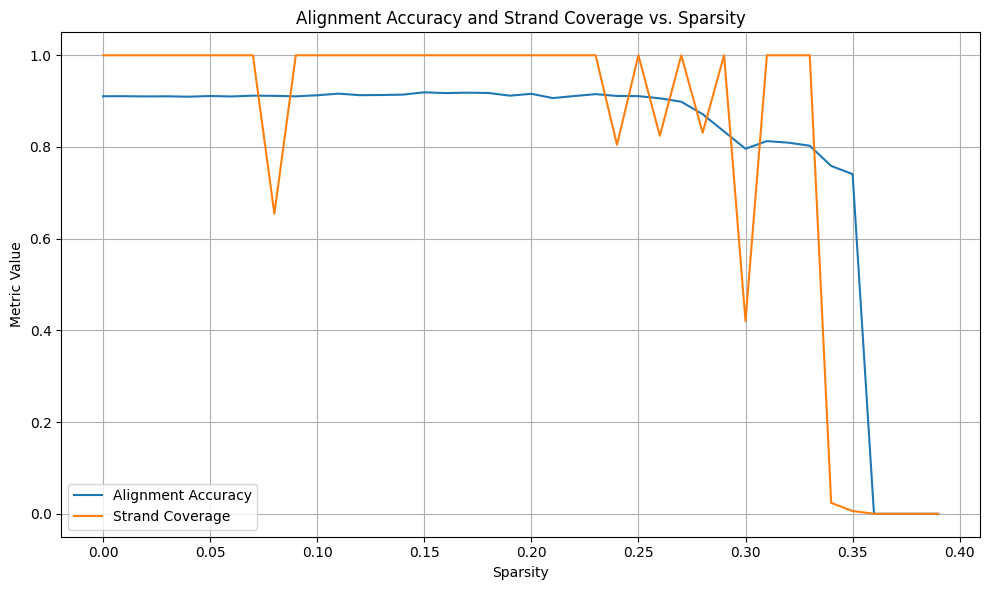

In [27]:
import matplotlib.pyplot as plt

# Extract and sort by sparsity value
sorted_items = sorted(data.items(), key=lambda x: float(x[0].split('_')[1]))

sparsities = [float(k.split('_')[1]) for k, _ in sorted_items]
accuracy = [float(v['alignment_accuracy']) for _, v in sorted_items]
strand_coverage = [float(v['alignment_strand_coverage']) for _, v in sorted_items]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sparsities, accuracy, label='Alignment Accuracy')
plt.plot(sparsities, strand_coverage, label='Strand Coverage')
plt.xlabel('Sparsity')
plt.ylabel('Metric Value')
plt.title('Alignment Accuracy and Strand Coverage vs. Sparsity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We then perform iterative pruning

In [8]:
iter_pruned_models = [f'step_{i}' for i in range(0,4)]

bash(
  [f'dorado basecaller {test_model_dir}/{model} sample.pod5 --emit-fastq > {model}.fastq' for model in iter_pruned_models] +
  [f'dorado aligner sample.fasta {model}.fastq > {model}.bam' for model in iter_pruned_models] +
  [f'dorado summary {model}.bam > {model}.tsv' for model in iter_pruned_models]
)

```bash
dorado basecaller /vol/bitbucket/bl1821/pruned_models/step_0 sample.pod5 --emit-fastq > step_0.fastq && 
dorado basecaller /vol/bitbucket/bl1821/pruned_models/step_1 sample.pod5 --emit-fastq > step_1.fastq && 
dorado basecaller /vol/bitbucket/bl1821/pruned_models/step_2 sample.pod5 --emit-fastq > step_2.fastq && 
dorado basecaller /vol/bitbucket/bl1821/pruned_models/step_3 sample.pod5 --emit-fastq > step_3.fastq && 
dorado aligner sample.fasta step_0.fastq > step_0.bam && 
dorado aligner sample.fasta step_1.fastq > step_1.bam && 
dorado aligner sample.fasta step_2.fastq > step_2.bam && 
dorado aligner sample.fasta step_3.fastq > step_3.bam && 
dorado summary step_0.bam > step_0.tsv && 
dorado summary step_1.bam > step_1.tsv && 
dorado summary step_2.bam > step_2.tsv && 
dorado summary step_3.bam > step_3.tsv
```

In [ ]:
data = {model: tsv_dict(model) for model in iter_pruned_models}
make_table(data)

NameError: name 'iter_pruned_models' is not defined

# The code below are legacy

Batch testing:

In [ ]:
# Batch processing

import os
import random

num_samples = 100
sequence_length = 300

for i in range(num_samples):
  # Create unique folder
  folder_name = f"small_rep_out/{i:03d}"
  os.makedirs(folder_name, exist_ok=True)

  # Generate random DNA sequence
  sequence = ''.join(random.choices('ACGT', k=sequence_length))

  # Write to data.txt
  with open(f"{folder_name}/data.txt", "w") as txt:
    txt.write(sequence)

  # Write to sample.fasta in 60nt per line
  with open(f"{folder_name}/sample.fasta", "w") as fasta:
    fasta.write(">random_sequence\n")
    for j in range(0, sequence_length, 60):
      fasta.write(sequence[j:j+60] + "\n")


In [32]:
bash(["""for i in $(seq -w 0 99); do
  cd "0$i" || { echo "❌ Failed to enter directory $i"; exit 1; }

  squigulator sample.fasta -x dna-r10-prom -o sample.slow5 --full-contigs --ont-friendly yes --seed 42 &&
  rm -f sample.pod5 &&
  blue-crab s2p sample.slow5 -o sample.pod5 &&
  
  dorado basecaller "$FAST" sample.pod5 --reference sample.fasta > fast.bam &&
  dorado summary fast.bam > fast.tsv &&

  dorado basecaller "$HAC" sample.pod5 --reference sample.fasta > hac.bam &&
  dorado summary hac.bam > hac.tsv &&

  dorado basecaller "$SUP" sample.pod5 --reference sample.fasta > sup.bam &&
  dorado summary sup.bam > sup.tsv

  cd ..

done"""])

```bash
for i in $(seq -w 0 99); do
  cd "0$i" || { echo "❌ Failed to enter directory $i"; exit 1; }

  squigulator sample.fasta -x dna-r10-prom -o sample.slow5 --full-contigs --ont-friendly yes --seed 42 &&
  rm -f sample.pod5 &&
  blue-crab s2p sample.slow5 -o sample.pod5 &&
  
  dorado basecaller "$FAST" sample.pod5 --reference sample.fasta > fast.bam &&
  dorado summary fast.bam > fast.tsv &&

  dorado basecaller "$HAC" sample.pod5 --reference sample.fasta > hac.bam &&
  dorado summary hac.bam > hac.tsv &&

  dorado basecaller "$SUP" sample.pod5 --reference sample.fasta > sup.bam &&
  dorado summary sup.bam > sup.tsv

  cd ..

done
```


📊 Markdown Summary Table:

| Model | Total | Failed | Aligned | Accuracy Mean | Accuracy Std | Identity Mean | Identity Std | Insertions Mean | Deletions Mean | Substitutions Mean |
|-------|--------|--------|---------|----------------|---------------|------------------|----------------|------------------|----------------|---------------------|
| fast | 100 | 53 | 47 | 0.8742 | 0.0225 | 0.9311 | 0.0163 | 4.6 | 13.0 | 18.4 |
| hac | 100 | 15 | 85 | 0.9037 | 0.0233 | 0.9491 | 0.0168 | 4.5 | 9.3 | 13.9 |
| sup | 100 | 16 | 84 | 0.9096 | 0.0265 | 0.9519 | 0.0197 | 5.3 | 7.7 | 13.4 |



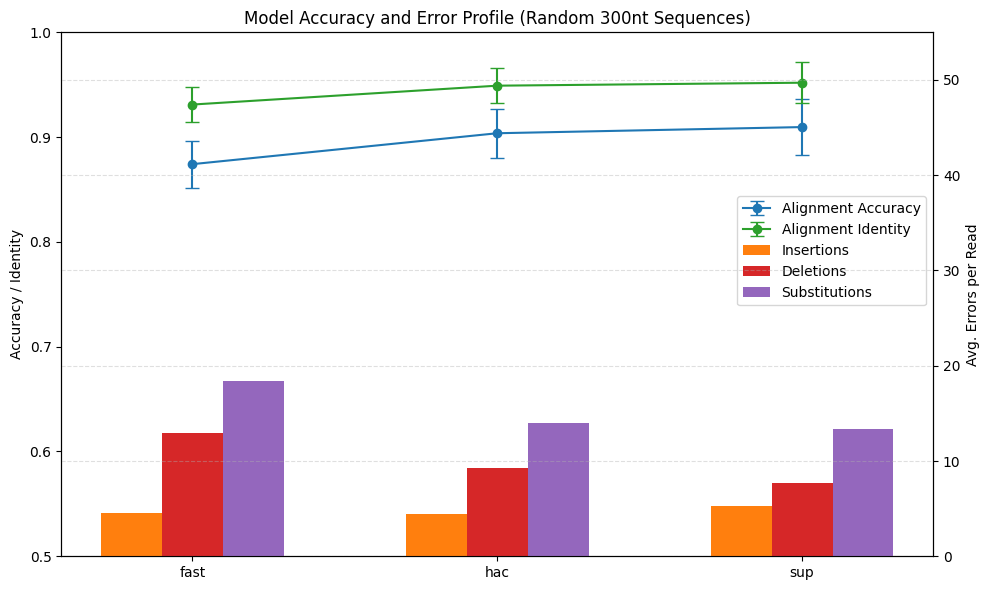

In [64]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

input_root = Path("small_rep_out")
models = ["fast", "hac", "sup"]
summary = []

for model in models:
    all_dfs = []

    for i in range(100):
        tsv_file = input_root / f"{i:03d}" / f"{model}.tsv"
        if not tsv_file.exists():
            continue
        df = pd.read_csv(tsv_file, sep="\t")
        all_dfs.append(df)

    if not all_dfs:
        continue

    df_combined = pd.concat(all_dfs, ignore_index=True)

    # Filter out failed reads (no alignment)
    failed = ((df_combined["alignment_accuracy"] == 0) | (df_combined["alignment_genome_start"] == -1)).sum()
    aligned = df_combined[(df_combined["alignment_accuracy"] > 0) & (df_combined["alignment_genome_start"] != -1)]

    summary.append({
        "Model": model,
        "Total Reads": len(df_combined),
        "Failed": failed,
        "Aligned": len(aligned),
        "Accuracy Mean": aligned["alignment_accuracy"].mean(),
        "Accuracy Std": aligned["alignment_accuracy"].std(),
        "Identity Mean": aligned["alignment_identity"].mean(),
        "Identity Std": aligned["alignment_identity"].std(),
        "Insertions Mean": aligned["alignment_num_insertions"].mean(),
        "Deletions Mean": aligned["alignment_num_deletions"].mean(),
        "Substitutions Mean": aligned["alignment_num_substitutions"].mean(),
    })

summary_df = pd.DataFrame(summary)

# ===== Markdown Summary Table =====
md_table = (
    "| Model | Total | Failed | Aligned | Accuracy Mean | Accuracy Std | "
    "Identity Mean | Identity Std | Insertions Mean | Deletions Mean | Substitutions Mean |\n"
    "|-------|--------|--------|---------|----------------|---------------|------------------|----------------|------------------|----------------|---------------------|\n"
)
for _, row in summary_df.iterrows():
    md_table += (
        f"| {row['Model']} | {row['Total Reads']} | {row['Failed']} | {row['Aligned']} | "
        f"{row['Accuracy Mean']:.4f} | {row['Accuracy Std']:.4f} | "
        f"{row['Identity Mean']:.4f} | {row['Identity Std']:.4f} | "
        f"{row['Insertions Mean']:.1f} | {row['Deletions Mean']:.1f} | {row['Substitutions Mean']:.1f} |\n"
    )

print("\n📊 Markdown Summary Table:\n")
print(md_table)

# ===== PLOT =====
x = summary_df["Model"]
x_pos = range(len(x))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy & Identity with T-bar error
ax1.errorbar(x_pos, summary_df["Accuracy Mean"], yerr=summary_df["Accuracy Std"],
             label="Alignment Accuracy", fmt="-o", capsize=5, color="tab:blue")
ax1.errorbar(x_pos, summary_df["Identity Mean"], yerr=summary_df["Identity Std"],
             label="Alignment Identity", fmt="-o", capsize=5, color="tab:green")
ax1.set_ylabel("Accuracy / Identity")
ax1.set_ylim(0.5, 1.0)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x)
ax1.tick_params(axis="y")

# Secondary axis for error counts
ax2 = ax1.twinx()
bar_width = 0.2
ax2.bar([p - bar_width for p in x_pos], summary_df["Insertions Mean"],
        width=bar_width, label="Insertions", color="tab:orange")
ax2.bar(x_pos, summary_df["Deletions Mean"],
        width=bar_width, label="Deletions", color="tab:red")
ax2.bar([p + bar_width for p in x_pos], summary_df["Substitutions Mean"],
        width=bar_width, label="Substitutions", color="tab:purple")
ax2.set_ylabel("Avg. Errors per Read")
ax2.set_ylim(0, 55)
ax2.tick_params(axis="y")

# Legend and layout
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + bars_labels[0],
           lines_labels[1] + bars_labels[1], loc="upper right", bbox_to_anchor=(1.0, 0.7))

plt.title("Model Accuracy and Error Profile (Random 300nt Sequences)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
# plt.savefig("random_seq_model_comparison_summary.png")
plt.show()


Sampling testing:


📊 Markdown Summary Table:

| Model | Total | Failed | Aligned | Accuracy Mean | Accuracy Std | Identity Mean | Identity Std | Insertions Mean | Deletions Mean | Substitutions Mean |
|-------|--------|--------|---------|----------------|---------------|------------------|----------------|------------------|----------------|---------------------|
| fast | 100 | 46 | 54 | 0.8595 | 0.0396 | 0.9349 | 0.0177 | 10.3 | 31.5 | 31.6 |
| hac | 100 | 20 | 80 | 0.8803 | 0.0308 | 0.9431 | 0.0194 | 7.3 | 24.9 | 25.8 |
| sup | 100 | 18 | 82 | 0.9149 | 0.0263 | 0.9565 | 0.0184 | 7.8 | 12.7 | 20.2 |



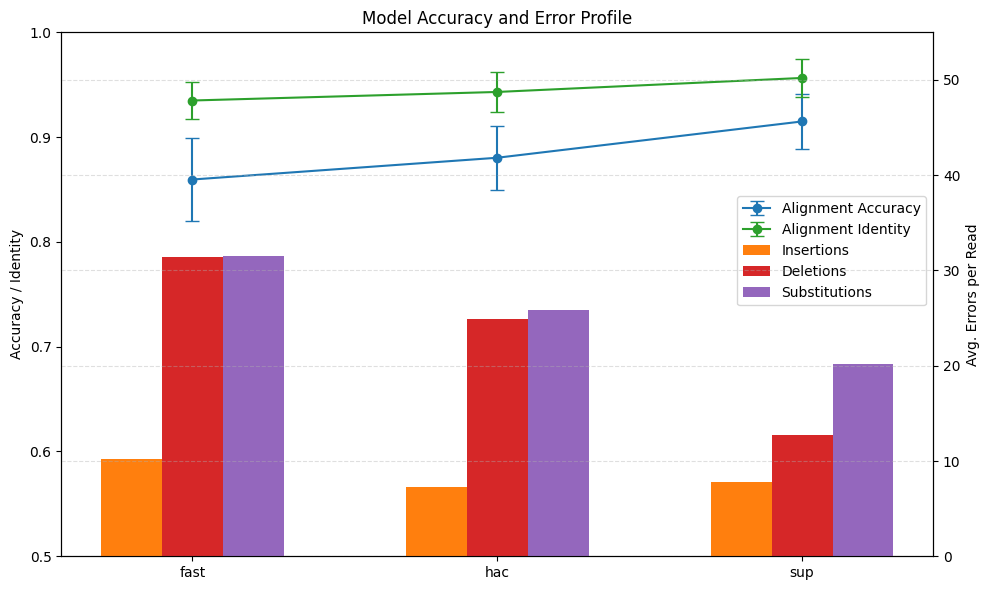

In [63]:
import os
import pandas as pd
import matplotlib.pyplot as plt

input_dir = "small_pick_out"
files = [f for f in os.listdir(input_dir) if f.endswith(".tsv")]

summary = []

for fname in sorted(files):
    model_name = fname.replace(".tsv", "")
    fpath = os.path.join(input_dir, fname)

    df = pd.read_csv(fpath, sep="\t")

    # Filter out failed reads
    failed = ((df["alignment_accuracy"] == 0) | (df["alignment_genome_start"] == -1)).sum()
    aligned = df[(df["alignment_accuracy"] > 0) & (df["alignment_genome_start"] != -1)]

    summary.append({
        "Model": model_name,
        "Total Reads": len(df),
        "Failed": failed,
        "Aligned": len(aligned),
        "Accuracy Mean": aligned["alignment_accuracy"].mean(),
        "Accuracy Std": aligned["alignment_accuracy"].std(),
        "Identity Mean": aligned["alignment_identity"].mean(),
        "Identity Std": aligned["alignment_identity"].std(),
        "Insertions Mean": aligned["alignment_num_insertions"].mean(),
        "Deletions Mean": aligned["alignment_num_deletions"].mean(),
        "Substitutions Mean": aligned["alignment_num_substitutions"].mean(),
    })

summary_df = pd.DataFrame(summary)

# Markdown Summary Table with separated mean and std columns
md_table = (
    "| Model | Total | Failed | Aligned | Accuracy Mean | Accuracy Std | "
    "Identity Mean | Identity Std | Insertions Mean | Deletions Mean | Substitutions Mean |\n"
    "|-------|--------|--------|---------|----------------|---------------|------------------|----------------|------------------|----------------|---------------------|\n"
)
for _, row in summary_df.iterrows():
    md_table += (
        f"| {row['Model']} | {row['Total Reads']} | {row['Failed']} | {row['Aligned']} | "
        f"{row['Accuracy Mean']:.4f} | {row['Accuracy Std']:.4f} | "
        f"{row['Identity Mean']:.4f} | {row['Identity Std']:.4f} | "
        f"{row['Insertions Mean']:.1f} | {row['Deletions Mean']:.1f} | {row['Substitutions Mean']:.1f} |\n"
    )

print("\n📊 Markdown Summary Table:\n")
print(md_table)

# ===== PLOT =====
x = summary_df["Model"]
x_pos = range(len(x))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy & Identity with T-bar error
ax1.errorbar(x_pos, summary_df["Accuracy Mean"], yerr=summary_df["Accuracy Std"],
             label="Alignment Accuracy", fmt="-o", capsize=5, color="tab:blue")
ax1.errorbar(x_pos, summary_df["Identity Mean"], yerr=summary_df["Identity Std"],
             label="Alignment Identity", fmt="-o", capsize=5, color="tab:green")
ax1.set_ylabel("Accuracy / Identity")
ax1.set_ylim(0.5, 1.0)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x)
ax1.tick_params(axis="y")

# Secondary axis for error counts
ax2 = ax1.twinx()
bar_width = 0.2
ax2.bar([p - bar_width for p in x_pos], summary_df["Insertions Mean"],
        width=bar_width, label="Insertions", color="tab:orange")
ax2.bar(x_pos, summary_df["Deletions Mean"],
        width=bar_width, label="Deletions", color="tab:red")
ax2.bar([p + bar_width for p in x_pos], summary_df["Substitutions Mean"],
        width=bar_width, label="Substitutions", color="tab:purple")
ax2.set_ylabel("Avg. Errors per Read")
ax2.set_ylim(0, 55)
ax2.tick_params(axis="y")

# Legend and layout
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + bars_labels[0],
           lines_labels[1] + bars_labels[1], loc="upper right", bbox_to_anchor=(1.0, 0.7))

plt.title("Model Accuracy and Error Profile")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
# plt.savefig("model_comparison_summary.png")
plt.show()

In [24]:
# Assuming the .fasta file contain a single read

def read_fasta(file_path):
  sequence = ""
  with open(file_path, 'r') as file:
    for line in file:
      line = line.strip()
      if line.startswith(">"):
        continue  # Skip header
      sequence += line
  return sequence

ref_sequence = read_fasta("test/sample.fasta")
len(ref_sequence)

3106848

In [34]:
def read_fastq(file_path):
  with open(file_path, 'r') as file:
    header = file.readline().strip()
    seq = file.readline().strip()
    _ = file.readline()
    qual = file.readline().strip()

    read = {
      "sequence": seq,
      "quality": qual,
      "avg_qscore": float(header.split("qs:f:")[1].split()[0])
    }
  return read

simulated_read = read_fastq("test/sample1.fastq")
len(simulated_read['sequence']), len(simulated_read['quality']), simulated_read['avg_qscore']

(3055325, 3055325, 11.4038)

In [ ]:
import edlib

ref = "ACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTG"
simulated = "CTCGCTCGCTCGCTCGCTCGCTCGCTCGCTTCGCTCGCTCGCTCGCTCGCTCGCTCGCTCGCTCGCTCGCTCGCTTCGCTCCGCTCGAC"

# Align and compute identity
result = edlib.align(ref, simulated, task="path")
identity = (len(ref) - result["editDistance"]) / len(ref) * 100
print(f"Accuracy: {identity:.2f}%")

Accuracy: 48.96%


In [15]:
import edlib

def calculate_accuracy(ref_seq, simulated_seq):
    alignment = edlib.align(ref_seq, simulated_seq, task="path")
    matches = len(ref_seq) - alignment["editDistance"]
    identity = (matches / len(ref_seq)) * 100
    return identity

ref_seq = ref_sequences["a_tale_of_two_cities"]
simulated_seq = simulated_reads["93e5f2d6-797e-48a8-9357-174bfb09e38e"]["sequence"]
accuracy = calculate_accuracy(ref_seq, simulated_seq)
accuracy

40.396

In [17]:
import uuid

input_file = f"{data_dir}/sample.slow5"
output_file = f"{data_dir}/fixed_sample.slow5"

with open(input_file) as fin, open(output_file, "w") as fout:
  for line in fin:
    if line.startswith("#") or line.startswith("@"):
      fout.write(line)
    else:
      parts = line.strip().split('\t')
      parts[0] = str(uuid.uuid4())  # replace read_id with UUID
      fout.write('\t'.join(parts) + '\n')
